In [1]:
import gc

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysheds.grid import Grid

plt.style.use("ggplot")

# Svalbard catchment delineation

# Notebook 02: Terrain processing

**This notebook requires a large machine (240 GB memory).**

This notebook performs terrain conditioning for Svalbard elevation data and generates flow direction and accumulations grids.

In [2]:
# Dataset resolutions to process
res_list = [10, 20, 40]

# Burning params
burn = True
max_iter = 1e9
eps = 1e-12

In [3]:
def vector_to_shapes(shp_path, crs="epsg:25833"):
    """Convert shapefile to a format suitable for rasterisation.

    Args
        crs: Str. Valid CRS string for geopandas

    Returns
        Tuple of tuples. Geometries for rasterising
    """
    gdf = gpd.read_file(shp_path).to_crs(crs)
    shapes = ((geom, 1) for geom in gdf.geometry)

    return shapes

In [4]:
%%time

# Set burning params
if burn:
    lakes_shp_path = r"/home/jovyan/shared/common/01_datasets/spatial/svalbard/vector/svalbard_lakes.shp"
    riv_shp_path = r"/home/jovyan/shared/common/01_datasets/spatial/svalbard/vector/svalbard_rivers.shp"
    stream_sigma = None
    stream_dz = 20
    lake_dz = 20
else:
    lakes_shp_path = None
    riv_shp_path = None
    stream_sigma = None
    stream_dz = None
    lake_dz = None    

for res in res_list:   
    # Projected and merged DEM created in notebook 1
    proj_dem_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_dem_proj_egm08.tif"

    # Datasets to create in this notebook
    if burn:
        fill_dem_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_filldem_burn_proj.tif"
        fdir_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_fdir_burn_proj.tif"
        facc_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_facc_burn_proj.tif"
    else:
        fill_dem_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_filldem_noburn_proj.tif"
        fdir_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_fdir_noburn_proj.tif"
        facc_path = f"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_{res}m/merged/svalbard_{res}m_facc_noburn_proj.tif"

    # Open proj_dem so we can get basic properties (extent etc.) later
    grid = Grid.from_raster(proj_dem_path)
    dem = grid.read_raster(proj_dem_path)

    if lakes_shp_path:
        lake_shapes = vector_to_shapes(lakes_shp_path, crs="epsg:25833")
    else:
        lake_shapes = None
    
    if riv_shp_path:
        stream_shapes = vector_to_shapes(riv_shp_path, crs="epsg:25833")
    else:
        stream_shapes = None

    # Terrain processing
    dem, fdir, facc = nivapy.spatial.condition_dem(
        proj_dem_path,
        fill_dem_path,
        fdir_path,
        facc_path,
        dem_dtype=np.float32,
        dem_ndv=-9999,
        burn=burn,
        stream_shapes=stream_shapes,
        lake_shapes=lake_shapes,
        stream_sigma=stream_sigma,
        stream_dz=stream_dz,
        lake_dz=lake_dz,
        max_iter=max_iter,
        eps=eps,
    )

    del grid, dem, fdir, facc
    gc.collect()

        svalbard_10m_filldem_burn_proj.tif has 140 pits and 1180129809 flats.


CPU times: user 3h 8min 12s, sys: 11min 13s, total: 3h 19min 26s
Wall time: 2h 34min 53s


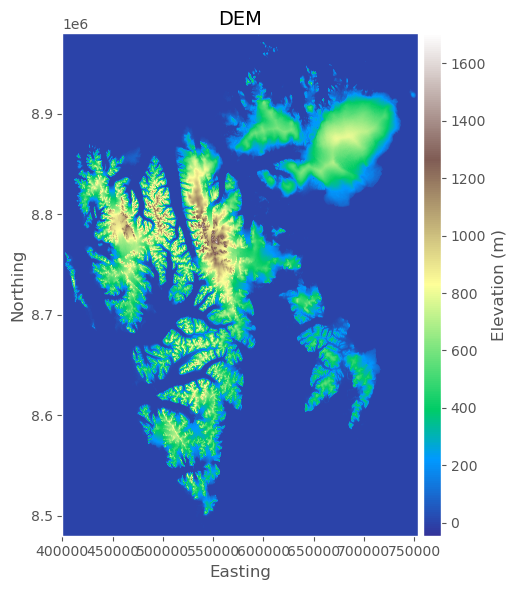

In [5]:
# Plot 40 m DEM
proj_dem_path = r"/home/jovyan/shared/common/01_datasets/spatial/svalbard/arctic_dem_40m/merged/svalbard_40m_dem_proj_egm08.tif"

grid = Grid.from_raster(proj_dem_path)
dem = grid.read_raster(proj_dem_path)
dem[dem==dem.nodata] = 0

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
im = ax.imshow(dem, extent=grid.extent, cmap="terrain", zorder=1)

# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Elevation (m)")

# Labels
ax.grid(zorder=0)
ax.set_title("DEM", size=14)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.tight_layout()

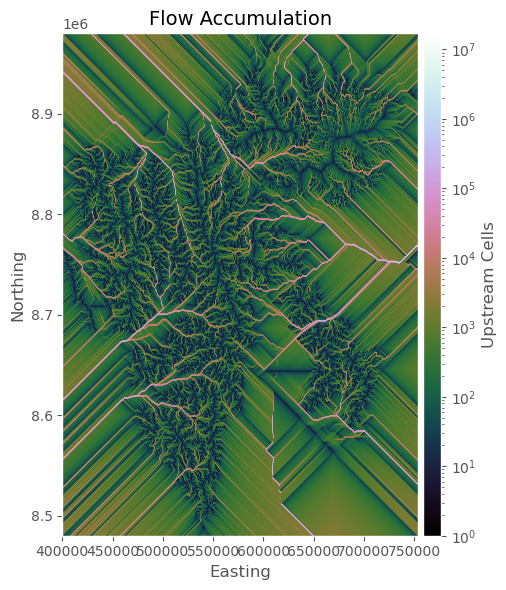

In [6]:
# Plot 40 m flow accumulation
grid = Grid.from_raster(facc_path)
facc = grid.read_raster(facc_path)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
im = ax.imshow(
    facc,
    extent=grid.extent,
    zorder=1,
    cmap="cubehelix",
    norm=colors.LogNorm(1, facc.max()),
    interpolation="bilinear",
)

# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label("Upstream Cells")

# Labels
ax.grid(zorder=0)
ax.set_title("Flow Accumulation", size=14)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
plt.tight_layout()